# MotilA Quick Start (Single File)

This script demonstrates how to use the **MotilA** pipeline for analyzing microglial fine process motility in a single 4D/5D image stack.

### Overview
- Loads and processes a registered 4D TIFF image stack.
- Applies preprocessing steps such as projection, registration, and spectral unmixing.
- Performs image enhancements like histogram equalization and filtering.
- Segments microglia, applies thresholding, and quantifies motility.
- Saves the results, including segmented images, histograms, and motility metrics.

### Usage
1. **Import libraries**  
   Import the necessary libraries and modules.
2. **Set parameters**  
   Modify the configuration parameters in the **"DEFINE MOTILA PARAMETERS"** section to fit your dataset.
3. **Run the script**  
   Execute the script to process the image stack and generate results.
4. **output**  
   Processed images, histograms, and analysis results are saved in the specified output folder for further analysis and parameter tuning.

### Dependencies
- Requires **MotilA** to be installed and accessible. (Download it from the GitHub repository.)


### Author
Fabrizio Musacchio,  March 20, 2025

## Installation
First, download the MotilA repository from GitHub. 

Then, create and activate a conda environment with the following packages:

```bash
conda create -n motila python=3.12 mamba -y
conda activate motila
mamba mamba install -y numpy scipy matplotlib scikit-image scikit-learn pandas tifffile zarr numcodecs openpyxl xlrd ipywidgets ipykernel ipympl
```

We have tested MotilA for Python 3.9 and higher. If you encounter any issues, please let us know.

**Don't forget to select the correct kernel in Jupyter Notebook (!)**

## 1. Import libraries and download the example data set
First, we import MotilA and other required libraries:

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from motila import motila as mt

**Note**: `sys.path.append('../motila')` is used to add the MotilA directory to the system path – relative to the current working directory. If you execute this notebook from a different location, you may need to adjust the path accordingly.

You can verify the correct import by running the following cell:

In [2]:
mt.hello_world()

Hello, World! Welcome to MotilA!


**Before you proceed, please make sure that you have downloaded the example data from Zenodo:** 

* [Gockel &  Nieves-Rivera (2025), doi: 10.5281/zenodo.15061566](https://zenodo.org/records/15061566)

Place the downloaded and extracted data set into the `example project` folder.

## 2. Define MotilA parameters
Next, we define the parameters for the MotilA pipeline.

### Input parameters
Define the input file path, the current animal ID, and the animal's group.

In [ ]:
# define data input paths:
Current_ID = "ID240103_P17_1"           # define the ID of the mouse/animal
group      = "blinded"                  # define the group of the mouse/animal
DATA_Path  = "../example project/Data/ID240103_P17_1/TP000/registered/"
                                        # define the path to the data folder; can be absolute or relative to the
                                        # location of this script
IMG_File   = "all stacks 4D reg.tif"    # define the image file name
fname      = Path(DATA_Path).joinpath(IMG_File)

### Projection parameters
MotilA will generate maximum intensity projections along the specified axes. For this, we need to define the projection center and ranges:

In [4]:
# define projection settings:
projection_layers_default = 44 # define number of z-layers to project for motility analysis
projection_center_default = 23 # define the center slice of the projection; a sub-stack of +/- projection_layers will be projected;
                               # if metadata.xls is present in project_tag folder, this value is ignored and
                               # the value from the metadata.xls is used instead (in batch processing only!)

### Output parameters
Define the output folder and the filename for saving the results:

In [5]:
# define results output path:
RESULTS_foldername = f"../motility_analysis/projection_center_{projection_center_default}/"
                                        # define the folder name (not the full path) for the results;
                                        # by default, a folder with this name is generated within the DATA_Path, 
                                        # but you can also define a relative path to this.

# here you don't need to change anything:
RESULTS_Path = Path(DATA_Path).joinpath(RESULTS_foldername)
mt.check_folder_exist_create(RESULTS_Path)

    folder already exists: /Volumes/Media/Workspace/MotilA example files/single_file/ID240103_P17_1/TP000/registered/../motility_analysis/projection_center_23 


### Clear previous results?
Define whether to clear the output folder before running the pipeline:

In [6]:
# previous results settings:
clear_previous_results = True # set to True if all files in RESULTS_Path folder should be deleted before processing

### Thresholding parameters
Define the thresholding method and parameters for segmenting microglia. 

As a **thresholding method** (`threshold_method`), you can choose between `otsu`, `li`, `isodata`, `mean`, `triangle`, `yen`, and `minimum`.

**`blob_pixel_threshold`** defines the minimum number of pixels for a blob to be considered a microglial cell.

With **`compare_all_threshold_methods`**, a plot is generated comparing all thresholding methods listed above to facilitate the selection of the best method.

In [7]:
# thresholding settings:
threshold_method = "otsu"     # choose from: otsu, li, isodata, mean, triangle, yen, minimum
blob_pixel_threshold = 100    # define the threshold for the minimal pixel area of a blob during the segmentation
compare_all_threshold_methods = True # if True, all threshold methods will be compared and saved in the plot folder

### Image enhancement parameters
Define the parameters for enhancing the images, such as histogram equalization and filtering.

With **`hist_equalization`** set to `True`, the pipeline will apply histogram equalization WITHIN each time (3D) stack. This enhances the contrast within each 3D stack. This can be particularly useful for images with low contrast or uneven illumination. The `hist_equalization_clip_limit` parameter controls the intensity clipping limit for the histogram equalization. A higher value increases the intensity range but may also amplify noise. The `hist_equalization_kernel_size` parameter defines the kernel size for the histogram equalization. The default is `None` which let's the function choose the kernel size automatically. In cases of occurring block artifacts, you can set a fixed kernel size (e.g., (8,8), (16,16), (24,24), ...).

With `hist_match` set to `True`, the pipeline will apply histogram matching BETWEEN the time (3D) stacks. This homogenizes the intensity distribution across the time stacks and acts as a bleaching correction. The `histogram_ref_stack` parameter defines the reference stack for histogram matching. This reference stack serves as the basis for matching the intensity distributions of all other stacks. Both, the output plot `Normalized average brightness drop rel. to t0.pdf` and Excel file `Normalized average brightness of each stack.xlsx` show the average brightness of each stack relative to the reference stack. This can help to assess the quality of each time point stack and which time points might be excluded from further analysis.

In [ ]:
# image enhancement settings:
hist_equalization = True              # enhance the histograms WITHIN EACH projected stack: True or False
hist_equalization_clip_limit = 0.05   # clip limit for the histogram equalization (default is 0.05);
                                      # the higher the value, the more intense the contrast enhancement, 
                                      # but also the more noise is amplified  
hist_equalization_kernel_size = None  # kernel size for the histogram equalization; 
                                      # None (default) for automatic, or use a tuple (x,y) for a fixed size;
                                      # when using a tuple, you can start increasing the values from multiples
                                      # of 8, e.g., (8,8), (16,16), (24,24), (32,32), ... (128,128), ...
                                      # start increasing the values if the images start to included block artifacts
hist_match = True               # match the histograms   ACROSS the stacks          : True or False
histogram_ref_stack = 0         # define the stack which should be used as reference for the histogram matching

### Image filtering parameters
Define the parameters for filtering the images, such as median filtering and Gaussian smoothing.

#### Median filtering
You have the option to filter on the single slices BEFORE the projection (**`median_filter_slices`**) and/or on the projected images (**`median_filter_projections`**). For both options, you can choose from:

* `False` (no filtering)
* `square` (square kernel): integer numbers (3, 5, 9)
* `circular` (disk-shaped kernel; analogous to the median filter in ImageJ/Fiji): only values >= 0.5 allowed/have an effect

When you apply median filtering, you need to additionally provide the kernel size (**`median_filter_window_slices`** for single slices and **`median_filter_window_projections`** for projections). Depending on the chosen filtering kernel method, you can choose a kernel size as listed above.

#### Gaussian smoothing
Gaussian smoothing further  enhances the contrast and reduces noise. Set

* `gaussian_sigma_proj` to 0: no smoothing, or
* `gaussian_sigma_proj` to a value > 0: the standard deviation of the Gaussian kernel.

In [9]:
# filter settings:
median_filter_slices             = 'circular' # median filter on SLICES BEFORE projecting
                                        # 'square', 'circular', or False
                                        # circular: floating point numbers allowed, not lower than 0.5 for circular
                                        # square: integer numbers (3, 5, 9)
median_filter_window_slices      = 1.55 # median filter window size on SLICES BEFORE projecting
                                        # circular: only values >= 0.5 allowed/have an effect
                                        # square: integer numbers (3, 5, 9)

median_filter_projections        = 'circular' # median filter on PROJECTIONS
                                        # square, circular, or False
median_filter_window_projections = 1.55 # median filter window size on PROJECTIONS
                                        # circular: only values >= 0.5 allowed/have an effect
                                        # square: integer numbers (3, 5, 9)
gaussian_sigma_proj = 1.00  # standard deviation of Gaussian (blur) filter applied on the projected stack
                            # set to 0 for turning off

### Channel parameters
Define the channel parameters for single-channel or two-channel data:

In [10]:
# channel settings: 
two_channel_default = True # define if the stack has two channels; if metadata.xls is present, this value is ignored
MG_channel_default  = 0    # define the channel of the Microglia; if metadata.xls is present, this value is ignored
N_channel_default   = 1    # define the channel of the Neurons/2nd channel; if metadata.xls is present, this value is ignored

**Note**: If your stack contains only one channel, set `two_channel_default = False`; any value set in `N_channel_default` will be ignored.

**Note**: If `metadata.xls` is present in `project_tag` folder, the above defined values (`two_channel_default`, `MG_channel_defaulta`, `N_channel_default`) are ignored and values from the metadata.xls are used instead  (**in batch processing only!**)

### Registration parameters
*MotilA* provides the option to register the image stacks. Two registration options are available:

* `regStack3d`: register slices WITHIN each 3D time-stack; `True` or `False`
* `regStack2d`: register projections on each other;  `True` or `False`

With `template_mode`you can define the template mode for the registration. Choose between `mean` (default), `median`, `max`, `min`, `std`, and `var`.

With `max_xy_shift_correction`, you can define the maximum allowed shift in x and y (and z) direction for the registration. This is useful to avoid overcorrection.

In [11]:
# registration settings:
regStack3d = True          # register slices WITHIN each 3D time-stack; True or False
regStack2d = False          # register projections on each other; True or False
template_mode = "max"       # set the template mode for the 3D registration; defines for both 3D and 2D registration
                            # choose from: mean, median, max, std, var.
max_xy_shift_correction = 100 # set the maximal shift in x/y direction for the 2D registration

### Spectral unmixing parameters
*MotilA* provides the option to perform spectral unmixing on two-channel data. At the moment, only a simple method is implemented, which subtracts the N-channel from the MG-channel. Set `spectral_unmixing` to `True` to enable this feature. 

With `spectral_unmixing_amplifyer_default` you can define the amplification factor for the MG-channel before subtraction. This can be useful to preserve more information in the MG-channel.

`spectral_unmixing_median_filter_window` defines the kernel size for median filtering of N-channel before subtraction. This can be useful to reduce noise in the N-channel and, thus, achieve a better unmixing result. Allowed are odd integer numbers (3, 5, 9, ...).

In [12]:
# spectral unmixing settings:
spectral_unmixing = True                  # perform spectral unmixing; True or False
                                          # if metadata.xls is present in project_tag folder, this value is 
                                          # ignored and the value from the metadata.xls is used instead 
                                          # (in batch processing only!)
spectral_unmixing_amplifyer_default    =1 # amplifies the MG channel (to save more from it)
spectral_unmixing_median_filter_window =3 # must be integer; 1=off, 3=common, 5=strong, 7=very strong

## 3. Initialize the logger
Initialize the logger to track the progress of the pipeline. The log file will be saved in the same folder as this notebook is located.

In [13]:
# init logger:
log = mt.logger_object()
log.log("logger started for TEST/DEBUG RUN.")
log.log("Test file: "+str(fname))
log.log(f"Mouse ID: {Current_ID}")
log.log(f"Group: {group}")

creating logger object...done.
logger started for TEST/DEBUG RUN.
Test file: /Volumes/Media/Workspace/MotilA example files/single_file/ID240103_P17_1/TP000/registered/all stacks 4D reg.tif
Mouse ID: ID240103_P17_1
Group: blinded


## 4. Run the MotilA pipeline
Finally, we run the *MotilA* pipeline with the defined parameters. Simply execute the following cell to start the processing:

In [ ]:
mt.process_stack(fname=fname,
                MG_channel=MG_channel_default, 
                N_channel=N_channel_default,
                two_channel=two_channel_default,
                projection_layers=projection_layers_default,
                projection_center=projection_center_default,
                histogram_ref_stack=histogram_ref_stack,
                log=log,
                blob_pixel_threshold=blob_pixel_threshold, 
                regStack2d=regStack2d,
                regStack3d=regStack3d,
                template_mode=template_mode,
                spectral_unmixing=spectral_unmixing,
                hist_equalization=hist_equalization,
                hist_equalization_clip_limit=hist_equalization_clip_limit,
                hist_equalization_kernel_size=hist_equalization_kernel_size,
                hist_match=hist_match,
                RESULTS_Path=RESULTS_Path,
                ID=Current_ID,
                group=group,
                threshold_method=threshold_method,
                compare_all_threshold_methods=compare_all_threshold_methods,
                gaussian_sigma_proj=gaussian_sigma_proj,
                spectral_unmixing_amplifyer=spectral_unmixing_amplifyer_default,
                median_filter_slices=median_filter_slices,
                median_filter_window_slices=median_filter_window_slices,
                median_filter_projections=median_filter_projections,
                median_filter_window_projections=median_filter_window_projections,
                clear_previous_results=clear_previous_results,
                spectral_unmixing_median_filter_window=spectral_unmixing_median_filter_window)

Processing file /Volumes/Media/Workspace/MotilA example files/single_file/ID240103_P17_1/TP000/registered/all stacks 4D reg.tif...
    folder already exists: /Volumes/Media/Workspace/MotilA example files/single_file/ID240103_P17_1/TP000/registered/../motility_analysis/projection_center_23 
Info: Folder /Volumes/Media/Workspace/MotilA example files/single_file/ID240103_P17_1/TP000/registered/../motility_analysis/projection_center_23 is not empty, deleting all files in it.
Projection center: 23, Projection range: [1, 44]
extracting sub-volumes and register them...
extracting sub-volumes...
   sub-volume extracting process time: 13.9243466854 sec
   registering 3D stack 0/8...
     registration of stack 0 process time: 9.7622518539 sec
   registering 3D stack 1/8...
     registration of stack 1 process time: 9.693267107 sec
   registering 3D stack 2/8...
     registration of stack 2 process time: 9.559237957 sec
   registering 3D stack 3/8...
     registration of stack 3 process time: 9.8

## 5. Assessing your results
After running the pipeline, you can assess the results in the specified output folder. The results of each processing step described above are saved in separate tif and PDF files. By carefully investigating these results, you can evaluate the quality of the processing and adjust the parameters if necessary.

An example assessment is given below. First, please execute the following cell:

In [61]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from IPython.display import display

# generate an interactive widget to slide through a tiff stack at a given path, cmap and title:
def browse_tiff_stack(path, cmap='gray', title='Title', figsize=(5, 5)):
    stack = tifffile.imread(path)
    def view_image(frame):
        plt.figure(figsize=figsize)
        plt.imshow(stack[frame], cmap=cmap)
        plt.title(f"{title} - frame={frame}")
        plt.axis('off')
        plt.show()
    frame_slider = widgets.IntSlider(min=0, max=stack.shape[0]-1, step=1, value=0)
    widgets.interact(view_image, frame=frame_slider)
    return


In [62]:
# example usage:
tif_path = "/Volumes/Media/Workspace/MotilA example files/single_file/ID240103_P17_1/TP000/motility_analysis/projection_center_23/"
title = "MG projected, proc 0 raw.tif"
tif_file = Path(tif_path).joinpath(title)
browse_tiff_stack(tif_file, cmap='gray', title=title)

interactive(children=(IntSlider(value=0, description='frame', max=7), Output()), _dom_classes=('widget-interac…

In [17]:
with tifffile.TiffFile(tif_path) as tif:
        image_stack = tif.asarray()

In [ ]:
import tifffile
import matplotlib.pyplot as plt
import ipywidgets as widgets
from pathlib import Path
%matplotlib widget

# generate an interactive widget to slide through a TIFF stack at a given path, cmap, and title
def browse_tiff_stack(path, cmap='gray', title='Title', figsize=(5, 5)):
    stack = tifffile.imread(path)
    
    # create the figure and axis once:
    fig, ax = plt.subplots(figsize=figsize)
    img = ax.imshow(stack[0], cmap=cmap)
    ax.set_title(f"{title} - frame=0")
    ax.axis('off')
    
    # function to update the image and title:
    def update_image(frame):
        img.set_data(stack[frame])  # update the image data
        ax.set_title(f"{title}\nframe={frame}")  # update the title
        fig.canvas.draw_idle()  # redraw the canvas without creating a new figure
    
    # create the slider widget:
    frame_slider = widgets.IntSlider(min=0, max=stack.shape[0]-1, step=1, value=0)
    widgets.interact(update_image, frame=frame_slider)
    return

interactive(children=(IntSlider(value=0, description='frame', max=7), Output()), _dom_classes=('widget-interac…

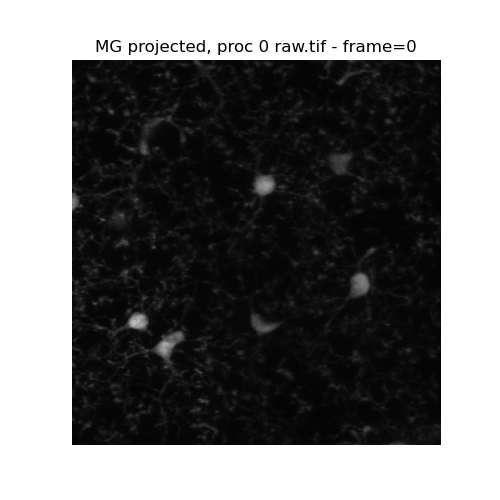

In [5]:
# example usage:
tif_path = "/Volumes/Media/Workspace/MotilA example files/single_file/ID240103_P17_1/TP000/motility_analysis/projection_center_23/"
title = "MG projected, proc 0 raw.tif"
tif_file = Path(tif_path).joinpath(title)
browse_tiff_stack(tif_file, cmap='gray', title=title)

Let's investigate the results of the **slice-wise median filtering**:

interactive(children=(IntSlider(value=0, description='frame', max=7), Output()), _dom_classes=('widget-interac…

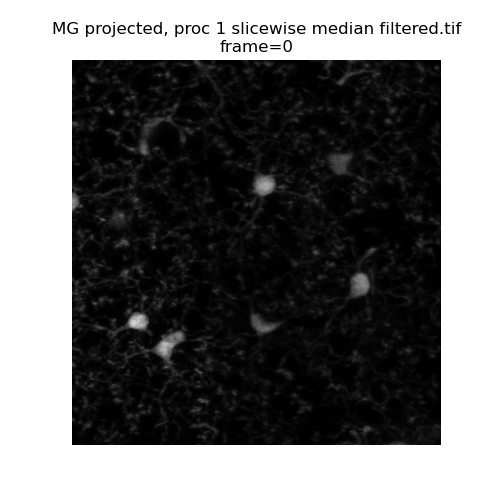

In [9]:
title = "MG projected, proc 1 slicewise median filtered.tif"
tif_file = Path(tif_path).joinpath(title)
browse_tiff_stack(tif_file, cmap='gray', title=title)

Let's investigate the results of the **histogram equalization**:

interactive(children=(IntSlider(value=0, description='frame', max=7), Output()), _dom_classes=('widget-interac…

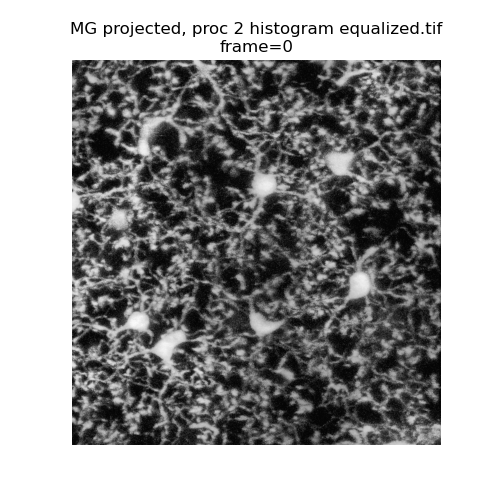

In [10]:
title = "MG projected, proc 2 histogram equalized.tif"
tif_file = Path(tif_path).joinpath(title)
browse_tiff_stack(tif_file, cmap='gray', title=title)

Let's investigate the results of the **histogram matching**:

interactive(children=(IntSlider(value=0, description='frame', max=7), Output()), _dom_classes=('widget-interac…

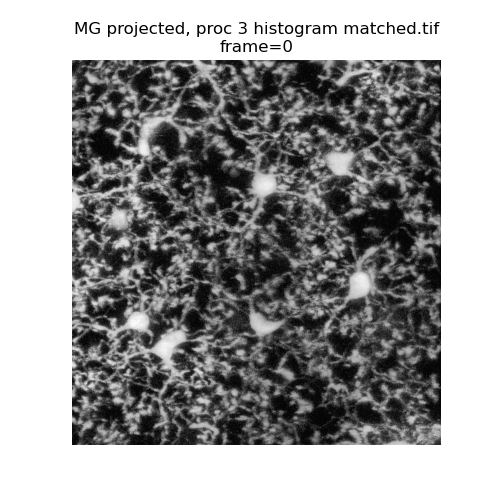

In [11]:
title = "MG projected, proc 3 histogram matched.tif"
tif_file = Path(tif_path).joinpath(title)
browse_tiff_stack(tif_file, cmap='gray', title=title)

Let's investigate the results of the **median filtering of the projections**:

interactive(children=(IntSlider(value=0, description='frame', max=7), Output()), _dom_classes=('widget-interac…

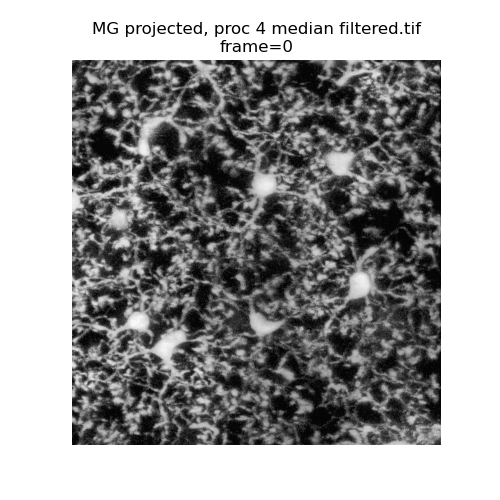

In [12]:
title = "MG projected, proc 4 median filtered.tif"
tif_file = Path(tif_path).joinpath(title)
browse_tiff_stack(tif_file, cmap='gray', title=title)

Let's investigate the results of the **Gaussian smoothing**:

interactive(children=(IntSlider(value=0, description='frame', max=7), Output()), _dom_classes=('widget-interac…

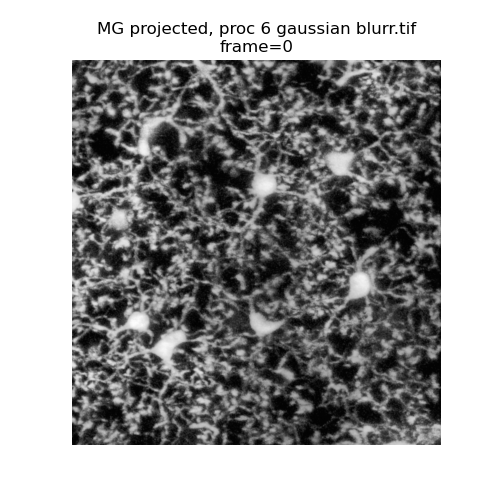

In [13]:
title = "MG projected, proc 6 gaussian blurr.tif"
tif_file = Path(tif_path).joinpath(title)
browse_tiff_stack(tif_file, cmap='gray', title=title)

Let's investigate the results of the final result of the motility analysis, i.e., the $\Delta t$ images where we have subtracted the binarized projection at time point $t_i$ from the binarized projection at time point $t_{i+1}$:

interactive(children=(IntSlider(value=0, description='frame', max=6), Output()), _dom_classes=('widget-interac…

' LEGEND:\nwhite:  background/no MG pixels\nblue:   stable MG pixels\ngreen:  gained MG pixels\nred:    lost MG pixels\n'

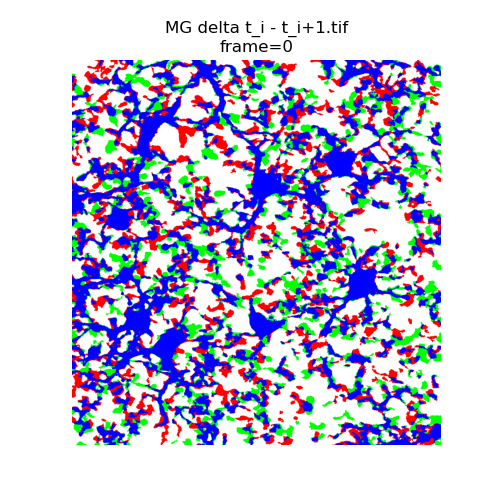

In [22]:
title = "MG delta t_i - t_i+1.tif"
tif_file = Path(tif_path).joinpath(title)
# define a colormap consisting og the colors white, blue, red and blue:
cmap = plt.cm.colors.ListedColormap(['lime', 'white', 'blue', 'red'])
browse_tiff_stack(tif_file, cmap=cmap, title=title)

""" LEGEND:
white:  background/no MG pixels
blue:   stable MG pixels
green:  gained MG pixels
red:    lost MG pixels
"""

Let's investigate the proportions of motile pixels in the $\Delta t$ images:

In [23]:
import pandas as pd
motility_table = "motility_analysis.xlsx"
motility_table_path = Path(tif_path).joinpath(motility_table)

motility_df = pd.read_excel(motility_table_path)
motility_df

,Unnamed: 0,delta t,ID,group,Stable,Gain,Loss,rel Stable,rel Gain,rel Loss,tor
0,0,t_0-t_1,ID240103_P17_1,blinded,433930,204228,217677,0.507025,0.238630,0.254345,0.492975
1,1,t_1-t_2,ID240103_P17_1,blinded,432111,212446,206047,0.508005,0.249759,0.242236,0.491995
2,2,t_2-t_3,ID240103_P17_1,blinded,405211,195933,239346,0.482113,0.233118,0.284770,0.517887
3,3,t_3-t_4,ID240103_P17_1,blinded,395125,212188,206019,0.485810,0.260887,0.253302,0.514190
4,4,t_4-t_5,ID240103_P17_1,blinded,394409,198677,212904,0.489347,0.246501,0.264152,0.510653
5,5,t_5-t_6,ID240103_P17_1,blinded,379787,254605,213299,0.448025,0.300351,0.251624,0.551975
6,6,t_6-t_7,ID240103_P17_1,blinded,423721,205224,210671,0.504660,0.244426,0.250914,0.495340


The motility analysis folder contains plots showing, e..g., absolute and relative pixel counts from this resuts table (e.g., `pixel counts relative t_0-t_1.pdf`, ...).

We can further take a look at both the average pixel brightness as well as the number of pixels ("pixel area") in each projected stack:

In [24]:
brightness_table = "relative brightness drops.xlsx"
brightness_table_path = Path(tif_path).joinpath(brightness_table)

brightness_df = pd.read_excel(brightness_table_path)
brightness_df

,Unnamed: 0,relative brightness drop
0,0,100.000000
1,1,101.140926
2,2,101.260427
3,3,104.792423
4,4,104.158241
5,5,104.220635
6,6,101.700479
7,7,101.930253


The average pixel brightness is an indicator of the overall intensity of the microglial cells in the image. A decreasing brightness over time could indicate bleaching or other issues. Note that the results show are those after applying the histogram matching (if chosen). Thus, if the average pixel brightness still drops even after histogram matching, the shown values may help to assess the quality each time point stack and which time points might be excluded from further analysis.

In the example above, the average pixel brightness is relatively stable over time, indicating that the histogram matching was successful in homogenizing the intensity distribution across the time stacks.

In [25]:
pixel_area_table = "pixel area sums.xlsx"
pixel_area_table_path = Path(tif_path).joinpath(pixel_area_table)

pixel_area_df = pd.read_excel(pixel_area_table_path)
pixel_area_df

,Unnamed: 0,t_i,cell area in pixel rel to stack 0,cell area in pixel total,total fov area in pixel
0,0,0,100.000000,651607,1644050
1,1,1,97.920679,638058,1644050
2,2,2,98.918060,644557,1644050
3,3,3,92.224915,600944,1644050
4,4,4,93.202344,607313,1644050
5,5,5,91.018973,593086,1644050
6,6,6,97.358070,634392,1644050
7,7,7,96.491443,628745,1644050


The cell pixel area is the number of segmented pixel of all (projected) MG cells per stack. Usually, this number should remain relatively stable over time as the cell motility does not imply a change in cell area/size. A decrease in cell pixel area could indicate a loss of cells over time, e.g., due to cell death or other issues. Bleaching or other issues could also lead to a decrease in cell pixel area. Thus, the same considerations as for the average pixel brightness apply here.

In the example above, the cell pixel area is relatively stable over time, indicating that the segmentation was successful in detecting the cells in the image.